# House market with Oracle AutoML, ADS, MLX

In [1]:
#import warnings
#warnings.filterwarnings('ignore')

import pandas as pd
import logging
import numpy as np
from sklearn import preprocessing

logging.basicConfig(format='%(levelname)s:%(message)s', level=logging.ERROR)

from ads.dataset.factory import DatasetFactory

In [2]:
#ds = DatasetFactory.open("housesales.csv", types = {'SalePrice': np.float64}, target="SalePrice")
ds = DatasetFactory.open("housesales.csv", target="SalePrice")

In [3]:
# show dataset summary, features, correlations and warnings all at once
ds.show_in_notebook()

Accordion(children=(HTML(value='<h1>Name: housesales.csv</h1><h3>Type: RegressionDataset</h3><h3>1,460 Rows, 8…

In [4]:
# instead of looking into the individual features, let's ask the ADS to provide us some recommendations
suggestion_df = ds.suggest_recommendations()

HTML(value='<li>detected wide dataset (81 columns)</li>')

HTML(value='<li>feature reduction using mutual information (max 16 columns)</li>')

In [5]:
ds.show_corr()

Loading BokehJS ...

HTML(value='<li>detected wide dataset (81 columns)</li>')

HTML(value='<li>feature reduction using mutual information (max 16 columns)</li>')

In [5]:
# show the recommended suggestions
suggestion_df

Code
Message                                Variables   Suggested                         Action                                                                 
Contains mostly unique values(100.00%) Id          Drop                              Drop                                              .drop_columns(["Id"])
                                                                                     Do nothing                                                             
Contains missing values(17.74%)        LotFrontage Fill missing values with frequent Drop                                     .drop_columns(["LotFrontage"])
                                                                                     Fill missing values with frequent        .fillna({"LotFrontage": 60.0})
                                                                                     Fill missing values with constant  .fillna({"LotFrontage": "constant"})
...                                                                                                                                                      ...
Contains missing values(80.75%)        Fence       Drop                              Do nothing                                                             
Contains missing values(96.30%)        MiscFeature Drop                              Drop                                     .drop_columns(["MiscFeature"])
                                                                                     Fill missing values with frequent      .fillna({"MiscFeature": "Shed"})
                                                                                     Fill missing values with constant  .fillna({"MiscFeature": "constant"})
                                                                                     Do nothing                                                             

[78 rows x 1 columns]

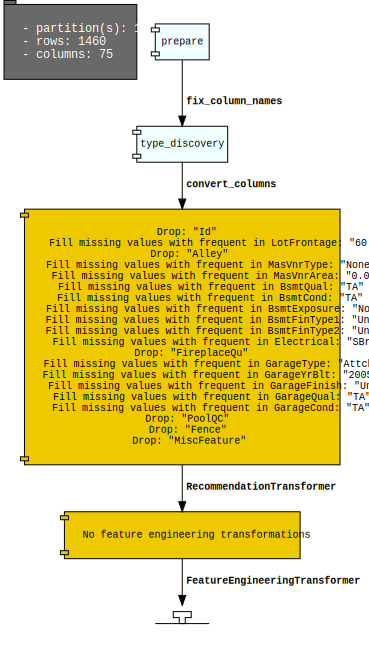

In [8]:
ds_transformed.visualize_transforms()

In [6]:
# check the number of current features
ds.summary()

,Feature,Datatype
0,SalePrice,continuous/float64
1,Id,ordinal/int16
2,MSSubClass,ordinal/int16
3,MSZoning,categorical/object
4,LotFrontage,ordinal/float64
...,...,...
76,MiscVal,ordinal/int16
77,MoSold,categorical/int8
78,YrSold,ordinal/int16
79,SaleType,categorical/object


In [7]:
# Will apply all the recommended transformations automatically
ds_transformed = ds.auto_transform()
type(ds_transformed)

ads.dataset.regression_dataset.RegressionDataset

In [9]:
# we can see we have now less features, 74
ds_transformed.summary()

,Feature,Datatype
0,SalePrice,ordinal/int32
1,MSSubClass,ordinal/int16
2,MSZoning,categorical/category
3,LotFrontage,ordinal/float64
4,LotArea,ordinal/int32
...,...,...
70,MiscVal,ordinal/int16
71,MoSold,categorical/category
72,YrSold,ordinal/int16
73,SaleType,categorical/category


In [10]:
# show some information about our target variable, which in our case is SalesPrice
ds_transformed.type_of_target()

{
  "type": "continuous",
  "missing_percentage": 0.0,
  "low_level_type": "float64",
  "stats": {
    "mode": 140000.0,
    "median": 163000.0,
    "kurtosis": 6.536281860064529,
    "variance": 6311111264.297448,
    "skewness": 1.8828757597682129,
    "outlier_percentage": 1.5068493150684932,
    "count": 1460.0,
    "mean": 180921.19589041095,
    "std": 79442.50288288662,
    "min": 34900.0,
    "25%": 129975.0,
    "50%": 163000.0,
    "75%": 214000.0,
    "max": 755000.0
  },
  "feature_name": "SalePrice"
}

In [11]:
# if you want to see what is in the dataframe now
ds_transformed

HTML(value='\n        <style>\n            .mostly-customized-scrollbar {\n              display: block;\n    …

RegressionDataset(target: SalePrice) 1,460 rows, 75 columns

In [31]:
# log the sales price
ds_transformed = ds_transformed.assign_column('SalePrice', lambda x: np.log(x))

In [32]:
ds_transformed['SalePrice'].head()

0    12.247694
1    12.109011
2    12.317167
3    11.849398
4    12.429216
Name: SalePrice, dtype: float64

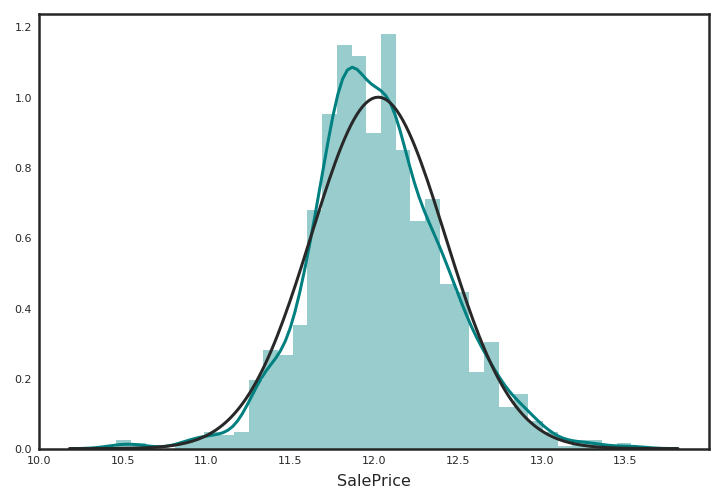

<Figure size 864x576 with 0 Axes>

In [34]:
#ds_transformed.target.show_in_notebook()
import seaborn as sns
from scipy.stats import norm
import matplotlib.pyplot as plot

sns.distplot(ds_transformed['SalePrice'], fit=norm)
fig = plot.figure()

In [35]:
# MAKE it Panda DataFrame Again
# data = ds_transformed.to_pandas_dataframe()

from ads.dataset.label_encoder import DataFrameLabelEncoder

ds_encoded = DataFrameLabelEncoder().fit_transform(ds_transformed.to_pandas_dataframe())
#ds_encoded['alcohol'].value_counts()


In [36]:
ds_encoded['MSZoning'].value_counts()

3    1151
4     218
1      65
2      16
0      10
Name: MSZoning, dtype: int64

In [51]:
ds_encoded.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,3,65.0,8450,1,3,3,0,4,0,...,0,0,0,0,0,2,2008,8,4,12.247694
1,20,3,80.0,9600,1,3,3,0,2,0,...,0,0,0,0,0,5,2007,8,4,12.109011
2,60,3,68.0,11250,1,0,3,0,4,0,...,0,0,0,0,0,9,2008,8,4,12.317167
3,70,3,60.0,9550,1,0,3,0,0,0,...,272,0,0,0,0,2,2006,8,0,11.849398
4,60,3,84.0,14260,1,0,3,0,2,0,...,0,0,0,0,0,12,2008,8,4,12.429216


In [41]:
y = ds_encoded['SalePrice']

In [42]:
X = ds_encoded.drop(['SalePrice'], axis=1)

In [43]:
X

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,3,65.0,8450,1,3,3,0,4,0,...,61,0,0,0,0,0,2,2008,8,4
1,20,3,80.0,9600,1,3,3,0,2,0,...,0,0,0,0,0,0,5,2007,8,4
2,60,3,68.0,11250,1,0,3,0,4,0,...,42,0,0,0,0,0,9,2008,8,4
3,70,3,60.0,9550,1,0,3,0,0,0,...,35,272,0,0,0,0,2,2006,8,0
4,60,3,84.0,14260,1,0,3,0,2,0,...,84,0,0,0,0,0,12,2008,8,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,60,3,62.0,7917,1,3,3,0,4,0,...,40,0,0,0,0,0,8,2007,8,4
1456,20,3,85.0,13175,1,3,3,0,4,0,...,0,0,0,0,0,0,2,2010,8,4
1457,70,3,66.0,9042,1,3,3,0,4,0,...,60,0,0,0,0,2500,5,2010,8,4
1458,20,3,68.0,9717,1,3,3,0,4,0,...,0,112,0,0,0,0,4,2010,8,4


In [50]:
y

0       12.247694
1       12.109011
2       12.317167
3       11.849398
4       12.429216
          ...    
1455    12.072541
1456    12.254863
1457    12.493130
1458    11.864462
1459    11.901583
Name: SalePrice, Length: 1460, dtype: float64

In [53]:
# EASY way to make the frame ADS again
ds_done = DatasetFactory.open(ds_encoded, target="SalePrice")

In [61]:
type(ds_done)

ads.dataset.regression_dataset.RegressionDataset

In [56]:
ds_done.head()
#ds_encoded['SalePrice']

HTML(value='\n        <style>\n            .mostly-customized-scrollbar {\n              display: block;\n    …

5 rows, 75 columns

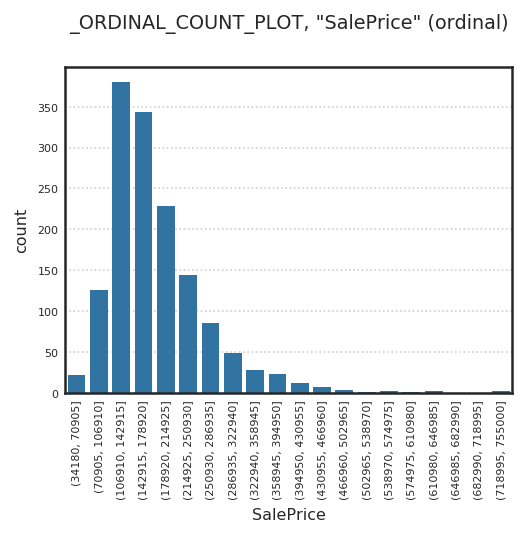

In [25]:
# visualize the distribution of the SalesPrice
ds_transformed.target.show_in_notebook()

In [58]:
# split the dataset to train and test
train, test = ds_done.train_test_split(test_size=0.2)
[train.X.shape, test.X.shape]

[(1148, 74), (312,)]

In [59]:
# Initialize the ADS AutoML Provider
from ads.automl.provider import OracleAutoMLProvider

# n_jobs = -1 means that we are not going to limit the resources and let the AutoML to do this for us and take as much as possible
ml_engine = OracleAutoMLProvider(n_jobs = -1)

In [72]:
# class DataFrameLabelEncoder(TransformerMixin):
#     def __init__(self):
#         self.label_encoders = defaultdict(LabelEncoder)
        
#     def fit(self, X):
#         for column in X.columns:
#             if X[column].dtype.name  in ["object", "category"]:
#                 self.label_encoders[column] = OrdinalEncoder()
#                 self.label_encoders[column].fit(X[column])
#         return self
    
#     def transform(self, X):
#         for column, label_encoder in self.label_encoders.items():
#             X[column] = label_encoder.transform(X[column])
#         return X

X = train.X.copy()
y = train.y.copy()

#le = DataFrameLabelEncoder()
#X = pd.get_dummies(X)
#X = le.fit_transform(X)

# ensemble_regressor = ExtraTreesRegressor(n_estimators=245, random_state=42)
# mlp_regressor = MLPRegressor(random_state=42)
lr = LinearRegression()
rr = Ridge(alpha=13.5)


# Train a baseline model
lr_model_fit = lr.fit(X, y)
rr_model_fit = rr.fit(X, y)

# ensemble_regressor.fit(X, y)
# mlp_regressor.fit(X, y)

#lr_model = ADSModel.from_estimator(make_pipeline(le, lr_model_fit), name="LinearRegression")
#rr_model = ADSModel.from_estimator(make_pipeline(le, rr_model_fit), name="Ridge")

lr_model = ADSModel.from_estimator(lr_model_fit, name="LinearRegression")
rr_model = ADSModel.from_estimator(rr_model_fit, name="Ridge")


print("Linear Score: {}\nRidge Score: {}".format(lr_model.score(train.X, train.y), 
                                                    rr_model.score(train.X, train.y)))

Linear Score: 0.9176605602354195
Ridge Score: 0.9164746077052447


In [73]:
y

0       12.247694
1       12.109011
2       12.317167
3       11.849398
6       12.634603
          ...    
1454    12.128111
1455    12.072541
1457    12.493130
1458    11.864462
1459    11.901583
Name: SalePrice, Length: 1148, dtype: float64

In [60]:
# Initialize the AutoML by using the provider above and train the model

from ads.automl.driver import AutoML
automl = AutoML(train, provider=ml_engine)
model, baseline = automl.train(time_budget=160, random_state=42)

Rank based on Performance,Algorithm,#Samples,#Features,Mean Validation Score,Hyperparameters,CPU Time
2,LGBMRegressor_HT,1148,71,-1.5764e-02,"{'boosting_type': 'gbdt', 'colsample_bytree': 1, 'max_depth': 63, 'n_estimators': 145, 'num_leaves': 8, 'reg_alpha': 0, 'reg_lambda': 0, 'subsample': 1}",3.4681
3,LGBMRegressor_HT,1148,71,-1.5766e-02,"{'boosting_type': 'gbdt', 'colsample_bytree': 1, 'max_depth': 63, 'n_estimators': 144, 'num_leaves': 8, 'reg_alpha': 0, 'reg_lambda': 0, 'subsample': 1}",3.2273
4,LGBMRegressor_HT,1148,71,-1.5776e-02,"{'boosting_type': 'gbdt', 'colsample_bytree': 1, 'max_depth': 63, 'n_estimators': 143, 'num_leaves': 8, 'reg_alpha': 0, 'reg_lambda': 0, 'subsample': 1}",3.2624
5,LGBMRegressor_HT,1148,71,-1.5846e-02,"{'boosting_type': 'gbdt', 'colsample_bytree': 1, 'max_depth': 3, 'n_estimators': 145, 'num_leaves': 7, 'reg_alpha': 0, 'reg_lambda': 0, 'subsample': 1}",2.5713
6,LGBMRegressor_HT,1148,71,-1.5866e-02,"{'boosting_type': 'gbdt', 'colsample_bytree': 1, 'max_depth': 3, 'n_estimators': 145, 'num_leaves': 31, 'reg_alpha': 0, 'reg_lambda': 0, 'subsample': 1}",2.4162
...,...,...,...,...,...,...
203,LGBMRegressor_HT,1148,71,-4.1975e+75,"{'boosting_type': 'goss', 'colsample_bytree': 1, 'max_depth': 63, 'n_estimators': 100, 'num_leaves': 8, 'reg_alpha': 0, 'reg_lambda': 0, 'subsample': 1}",1.9092
204,LGBMRegressor_HT,1148,71,-9.0097e+75,"{'boosting_type': 'goss', 'colsample_bytree': 0.5029790303129982, 'max_depth': 63, 'n_estimators': 100, 'num_leaves': 31, 'reg_alpha': 0, 'reg_lambda': 0, 'subsample': 1}",1.5656
205,LGBMRegressor_HT,1148,71,-1.1976e+76,"{'boosting_type': 'goss', 'colsample_bytree': 1, 'max_depth': 63, 'n_estimators': 100, 'num_leaves': 31, 'reg_alpha': 0, 'reg_lambda': 0, 'subsample': 1}",2.2359
206,LGBMRegressor_HT,1148,71,-2.0831e+76,"{'boosting_type': 'goss', 'colsample_bytree': 1, 'max_depth': 3, 'n_estimators': 145, 'num_leaves': 31, 'reg_alpha': 0, 'reg_lambda': 0, 'subsample': 1}",1.6461


# Model Evaluation

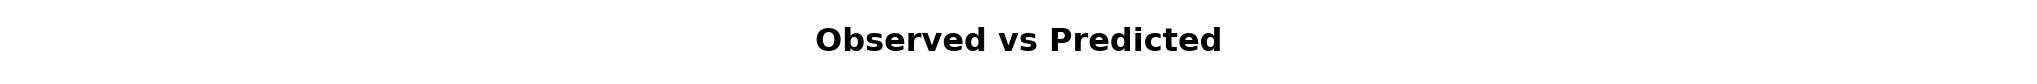

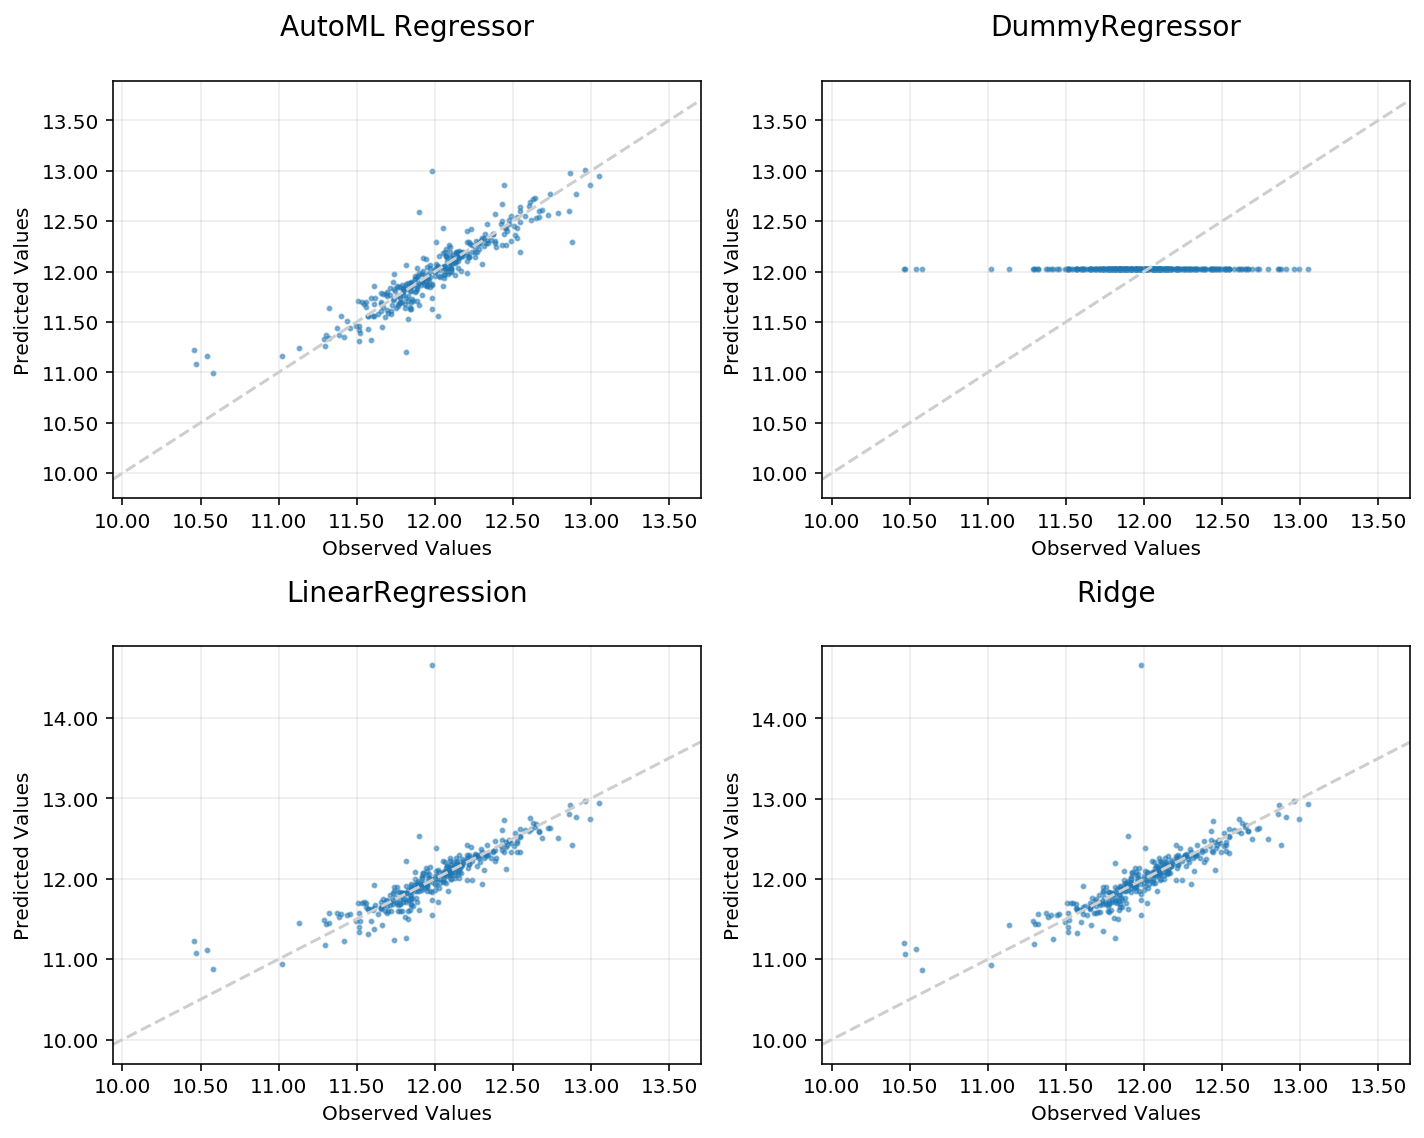

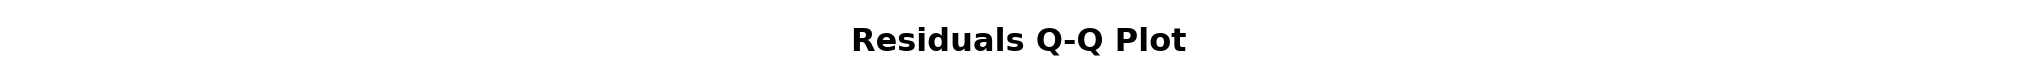

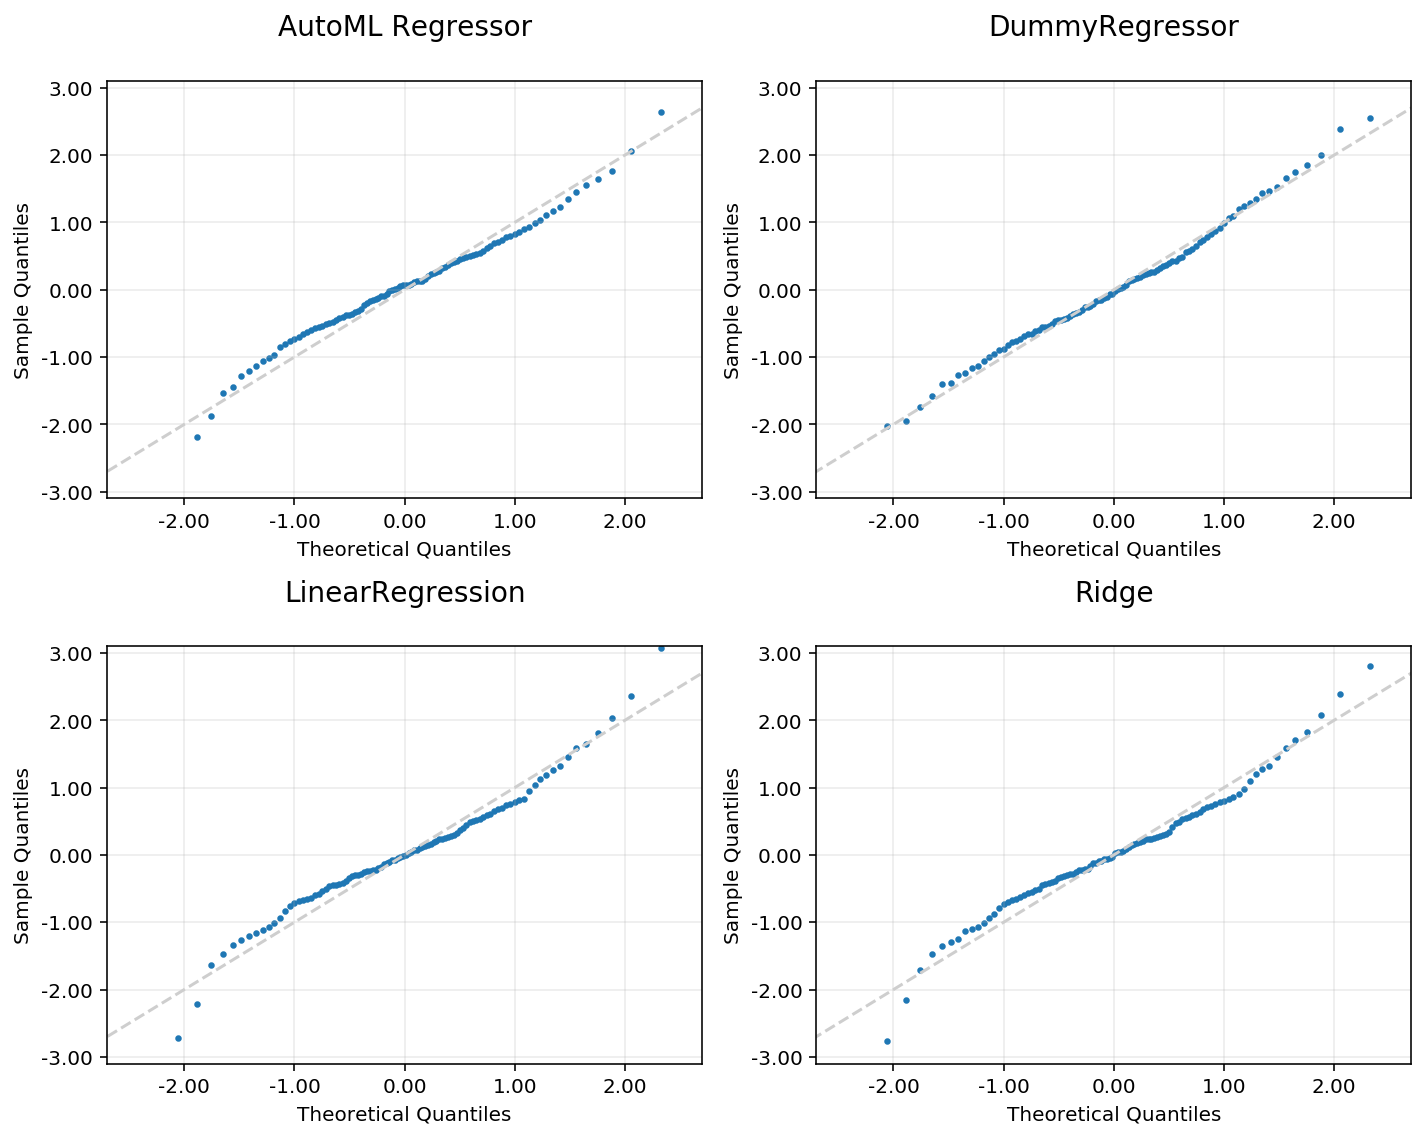

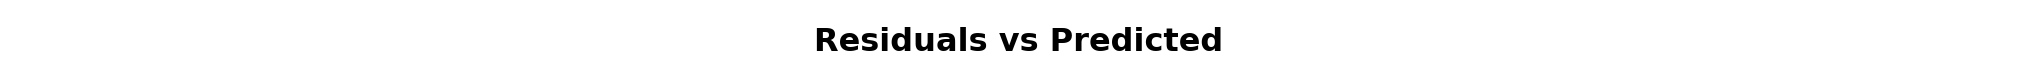

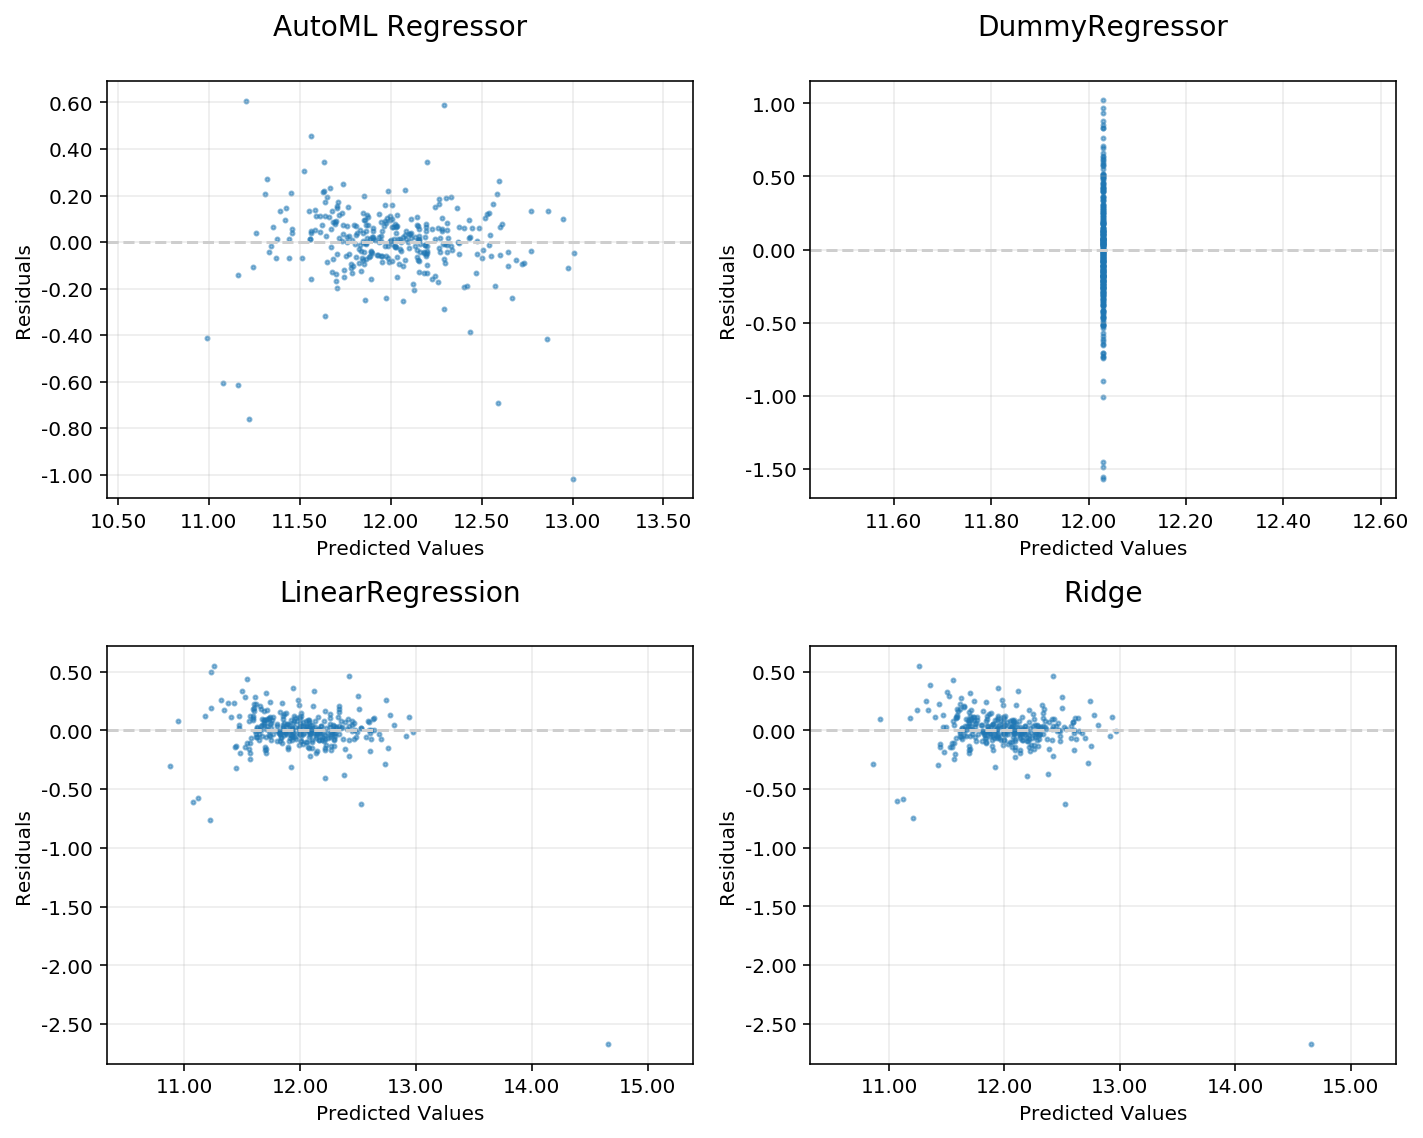

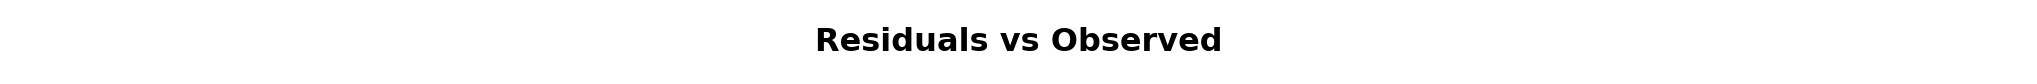

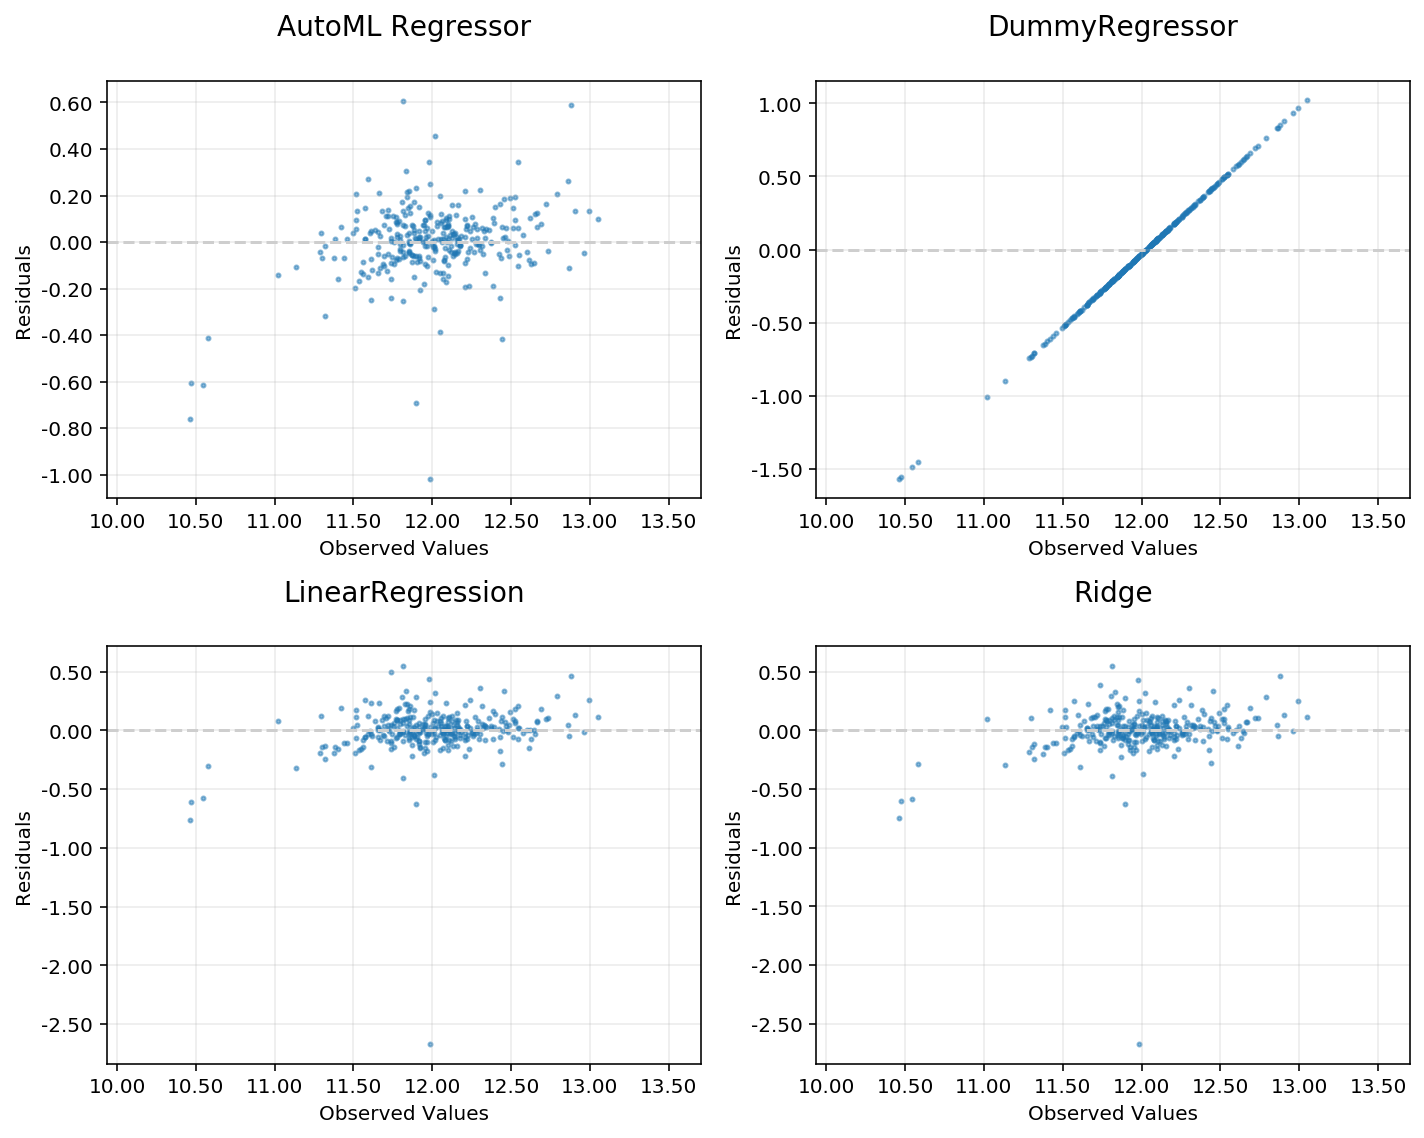

In [75]:
evaluator = ADSEvaluator(test, models=[model, baseline, lr_model, rr_model], training_data=train)
evaluator.show_in_notebook()

In [71]:
from sklearn.linear_model import Ridge, Lasso, LinearRegression

from ads.dataset.dataset_browser import DatasetBrowser
from ads.dataset.factory import DatasetFactory
from ads.automl.provider import OracleAutoMLProvider
from ads.automl.driver import AutoML
from ads.evaluations.evaluator import ADSEvaluator
from ads.explanations.explainer import ADSExplainer
from ads.explanations.mlx_global_explainer import MLXGlobalExplainer
from ads.explanations.mlx_local_explainer import MLXLocalExplainer
from ads.common.model import ADSModel
from category_encoders.ordinal import OrdinalEncoder
from collections import defaultdict
from sklearn.base import RegressorMixin
from sklearn.base import TransformerMixin
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelEncoder
# from sklearn.ensemble import ExtraTreesRegressor
# from sklearn.neural_network import MLPRegressor

<a id='explanations'></a>
# Model Explanations

The remaining part of this tutorial demonstrates how we can use the ADS explanation module to help better understand the behavior of our trained model. We will first create the required ADS explainer objects and then begin generating global and local explanations. 

Some useful terms for machine learning explainability (MLX):
  - **Explainability**: The ability to explain the reasons behind an machine learning model’s prediction.
  - **Interpretability**: The level at which a human can understand the explanation.
  - **Global Explanations**: Understand the general behavior of a machine learning model as a whole.
  - **local Explanations**: Understand why the machine learning model made a specific prediction.
  - **Model-Agnostic Explanations**: Explanations treat the machine learning model (and feature pre-processing) as a black-box, instead of using properties from the model to guide the explanation.

The ADS explanation module provides interpretable, model-agnostic, local/global explanations.

---

# ADS Explainer

In [76]:
explainer = ADSExplainer(test, lr_model, training_data=train)

In [74]:
ADS provides a general explainer object, `ADSExplainer`, which is used to generate both global and local explanations for machine learning models. `ADSExplainer` takes as input the datasets used to train and evaluate the model (e.g., train and test) and the model itself. The examples below will explain the output of the `ExtraTreesRegressor` model. However, any type of model (including an Oracle AutoML model) containing a `predict_proba()` or `predict()` function can be used. 

SyntaxError: invalid syntax (<ipython-input-74-48b7117ce988>, line 1)

In [77]:
global_explainer = explainer.global_explanation(provider=MLXGlobalExplainer())

In [78]:
# feature importance
global_explainer.feature_importance_summary()

In [79]:
importances = global_explainer.compute_feature_importance()

In [80]:
importances.show_in_notebook()

In [81]:
importances.show_in_notebook(n_features=5)

In [83]:
importances.show_in_notebook(n_features=3, mode='box_plot')

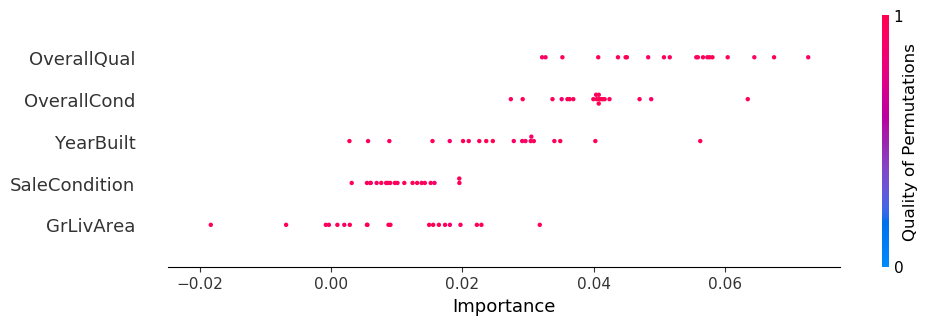

In [82]:
importances.show_in_notebook(n_features=5, mode='detailed')

<a id='pdp_ice'></a>
### Feature Dependence Explanations (PDP & ICE)

Next, we will generate global explanations to visualize how different values for the important features interact with the target variable. This is done through Partial Dependence Plots (PDP) and Individual Conditional Expectations (ICE) explanations. 

The following cell shows how to learn more about the PDP and ICE techniques used in the `MLXGlobalExplainer`. This provides a description of the algorithm and how to interpret the output. 

In [53]:
global_explainer.partial_dependence_summary()

In [85]:
pdp_lstat = global_explainer.compute_partial_dependence("OverallQual")

In [86]:
pdp_lstat.show_in_notebook()

In [87]:
# visualize the second most important feature
pdp_rm = global_explainer.compute_partial_dependence("GrLivArea")
pdp_rm.show_in_notebook()

In [88]:
# let's compute also the one from the Warning with the high correlation
pdp_lstat_rm = global_explainer.compute_partial_dependence(['GrLivArea', 'TotRmsAbvGrd'])
pdp_lstat_rm.show_in_notebook()

In [89]:
pdp_lstat_rm = global_explainer.compute_partial_dependence(['OverallQual', "GrLivArea"])
pdp_lstat_rm.show_in_notebook()

In [90]:
pdp_lstat.show_in_notebook(mode='ice')

In [91]:
pdp_rm.show_in_notebook(mode='ice', centered=True)

In [92]:
pdp_lstat.get_diagnostics()

{'pdp': [{'OverallQual': 2.0,
   'mean': 11.777657038431919,
   'std': 0.3171028760455333},
  {'OverallQual': 3.0, 'mean': 11.838579967042282, 'std': 0.3171028760455332},
  {'OverallQual': 4.0, 'mean': 11.899502895652645, 'std': 0.3171028760455332},
  {'OverallQual': 5.0, 'mean': 11.960425824263009, 'std': 0.3171028760455333},
  {'OverallQual': 6.0, 'mean': 12.021348752873374, 'std': 0.3171028760455333},
  {'OverallQual': 7.0, 'mean': 12.08227168148374, 'std': 0.3171028760455332},
  {'OverallQual': 8.0, 'mean': 12.1431946100941, 'std': 0.3171028760455332},
  {'OverallQual': 9.0, 'mean': 12.204117538704466, 'std': 0.3171028760455333},
  {'OverallQual': 10.0, 'mean': 12.26504046731483, 'std': 0.3171028760455332}],
 'explanation_stats': {'Runtime analysis': {'samples': {'value': [0.45323967933654785],
    'work': [9]},
   'samples average': 0.45323967933654785,
   'samples total': 0.45323967933654785,
   'work average': 9.0,
   'work total': 9,
   'samples throughput': 19.857043437093147,

In [96]:
<a id='local'></a>
## Local Explanations

Lastly, we will highlight how to generate local explanations using ADS. While global explanations help to understand the model's behavior as a whole, local explanations help to understand a single prediction from the model. Certain features might not be important for every instance (or the majority of instances) in our dataset, as highlighted in the global explanation, but may have a larger impact on specific instances.

We can create a local explainer object from the `ADSExplainer` to generate local model explanations. Oracle Labs local MLX is selected as the provider using the `MLXLocalExplainer` object. 

SyntaxError: invalid syntax (<ipython-input-96-d2f0ac9762f4>, line 1)

In [93]:
# this is still the LogisticRegression Model
local_explainer = explainer.local_explanation(provider=MLXLocalExplainer())

In [94]:
# if you want to see some explaination what algorithms will be used
#local_explainer.summary()

testX = test.X.copy()
testy = test.y.copy()

#testLe = DataFrameLabelEncoder()

#testX = pd.get_dummies(testX)
#test2 = testLe.fit_transform(testX)

In [98]:
#testX.head()
test.X.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition
4,60,3,84.0,14260,1,0,3,0,2,0,...,84,0,0,0,0,0,12,2008,8,4
5,50,3,85.0,14115,1,0,3,0,4,0,...,30,0,320,0,0,700,10,2009,8,4
7,60,3,60.0,10382,1,0,3,0,0,0,...,204,228,0,0,0,350,11,2009,8,4
8,50,4,51.0,6120,1,3,3,0,4,0,...,0,205,0,0,0,0,4,2008,8,0
19,20,3,70.0,7560,1,3,3,0,4,0,...,0,0,0,0,0,0,5,2009,0,0


In [138]:
testX

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
4,60,84.0,14260,8,5,2000,2000,350.0,655,0,...,0,0,0,1,0,0,0,0,1,0
5,50,85.0,14115,5,5,1993,1995,0.0,732,0,...,0,0,0,1,0,0,0,0,1,0
7,60,60.0,10382,7,6,1973,1973,240.0,859,32,...,0,0,0,1,0,0,0,0,1,0
8,50,51.0,6120,7,5,1931,1950,0.0,0,0,...,0,0,0,1,1,0,0,0,0,0
19,20,70.0,7560,5,6,1958,1965,0.0,504,0,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1429,20,60.0,12546,6,7,1981,1981,310.0,678,0,...,0,0,0,1,0,0,0,0,1,0
1431,120,60.0,4928,6,6,1976,1976,0.0,958,0,...,0,0,0,1,0,0,0,0,1,0
1444,20,63.0,8500,7,5,2004,2004,106.0,0,0,...,0,0,0,1,0,0,0,0,1,0
1453,20,90.0,17217,5,5,2006,2006,0.0,0,0,...,0,0,0,1,1,0,0,0,0,0


In [135]:
testy

4       250000
5       143000
7       200000
8       129900
19      139000
         ...  
1429    182900
1431    143750
1444    179600
1453     84500
1458    142125
Name: SalePrice, Length: 312, dtype: int32

In [143]:
testy.iloc[35:35+1]

143    204000
Name: SalePrice, dtype: int32

In [141]:
testX.iloc[35:35+1]

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
143,20,78.0,10335,7,5,1999,1999,183.0,679,0,...,0,0,0,1,0,0,0,0,1,0


In [99]:
# let's get sample 35 see what the price is, and compare with what our algorithm will suggest
sample = 35
(X, y) = test.X.iloc[sample:sample+1], test.y.iloc[sample:sample+1]
print(y)
print(lr_model.predict(X))

144    11.736069
Name: SalePrice, dtype: float64
[11.89621266]


In [100]:
# Next, we can call explain() to generate the local explanation for the selected instance.
explanation = local_explainer.explain(test.X.iloc[sample:sample+1], test.y.iloc[sample:sample+1])

In [101]:
explanation.show_in_notebook()

Feature,Value
Condition2,2.0
OverallQual,5.0
OverallCond,5.0
Utilities,0.0
TotalBsmtSF,1728.0
TotRmsAbvGrd,10.0
ScreenPorch,0.0
BsmtFinSF1,1332.0
1stFlrSF,1728.0
KitchenAbvGr,2.0
